In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [46]:
import matplotlib
matplotlib.__version__

'2.2.3'

## Engineering

In [295]:
df = pd.read_csv('data/covid_19_data.csv')
qc = df[df['Province/State'] == 'Quebec'].copy().reset_index()
qc['ObservationDate'] = pd.to_datetime(qc['ObservationDate'])
# qc['DateUnix'] = (pd.to_datetime(qc['ObservationDate']).astype(int) / 10**9).astype(float)
qc['DateUnix'] = qc['ObservationDate'].apply(lambda date: date.toordinal())
qc['DateUnix2'] = (qc['DateUnix'] ** 2).astype(float)
qc['DateUnix3'] = (qc['DateUnix'] ** 3).astype(float)
qc['ObsDateMs'] = pd.to_datetime(qc['ObservationDate'], unit='ms')

"""
Calculating daily change
"""
qc.loc[0, 'DailyDeaths'] = qc.loc[0, 'Deaths']
qc.loc[0, 'DailyConfirmed'] = qc.loc[0, 'Confirmed']
for i in range(1, len(qc)):
    changeD = qc.loc[i, 'Deaths'] - qc.loc[i-1, 'Deaths'] 
    changeC = qc.loc[i, 'Confirmed'] - qc.loc[i-1, 'Confirmed'] 
    qc.loc[i, 'DailyDeaths'] = changeD if changeD >= 0 else 0
    qc.loc[i, 'DailyConfirmed'] = changeC if changeC >= 0 else 0

"""
We have random daily spikes of ~8000 cases for a given day, 
We'll isolate those based on Bing's chart, which shows a max count of
daily cases of approx 4000.
https://www.bing.com/covid/local/quebec_canada
"""
qc = qc[qc['DailyConfirmed'] <= 4000]

"""
To make up for internal factors of the reporting system
of cases, we'll remove 0 DailyConfirmed rows.
"""
qc = qc[qc['DailyConfirmed'] > 0]

imp_dates = ['20/3/2020', '31/8/2020','25/12/2020']
# qc

/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


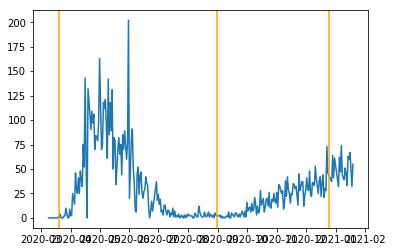

In [296]:
plt.plot(qc['ObservationDate'],qc['DailyDeaths'])
for d in imp_dates:
    plt.axvline(x=pd.to_datetime(d), color='orange')
plt.show()

/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/jlmy/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


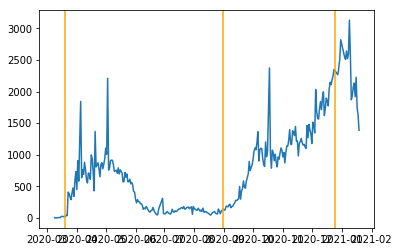

In [297]:
plt.plot(qc['ObservationDate'],qc['DailyConfirmed'])
for d in imp_dates:
    plt.axvline(x=pd.to_datetime(d), color='orange')
plt.show()

## Split and fit

In [298]:
delimiters = [
    '1/1/2020',
    '3/20/2020',
    '5/1/2020',
    '6/1/2020',
    '8/31/2020',
    '11/1/2020',
    '12/25/2020',
    '1/20/2021'
]
tranches = [[delimiters[i-1], delimiters[i]] for i in range(1,len(delimiters))]

sets = [
    qc[
        (pd.to_datetime(tranches[i][0]) < qc['ObservationDate']) & (qc['ObservationDate'] <= pd.to_datetime(tranches[i][1]))
    ] for i in range(len(tranches))
]
tranches
# qc[(qc['ObservationDate'] >= pd.to_datetime('3/20/2020')) & ( pd.to_datetime('5/1/2020') >= qc['ObservationDate'])]

[['1/1/2020', '3/20/2020'],
 ['3/20/2020', '5/1/2020'],
 ['5/1/2020', '6/1/2020'],
 ['6/1/2020', '8/31/2020'],
 ['8/31/2020', '11/1/2020'],
 ['11/1/2020', '12/25/2020'],
 ['12/25/2020', '1/20/2021']]

 
For: ['1/1/2020', '3/20/2020'] R2 0.7343813235074913
              Coef.      Std.Err.         t     P>|t|    [0.025    0.975]
const     -0.000006  1.292919e-06 -4.955055  0.000786 -0.000009 -0.000003
DateUnix  -2.362386  4.767628e-01 -4.955055  0.000786 -3.440898 -1.283874
DateUnix2  0.000003  6.464593e-07  4.955091  0.000786  0.000002  0.000005
 
For: ['3/20/2020', '5/1/2020'] R2 0.6701687620095523
               Coef.  Std.Err.         t         P>|t|     [0.025     0.975]
const      -0.000040  0.000006 -6.945812  3.866968e-08  -0.000052  -0.000028
DateUnix  -14.760975  2.125162 -6.945812  3.866968e-08 -19.071003 -10.450947
DateUnix2   0.000020  0.000003  6.946218  3.862219e-08   0.000014   0.000026
 
For: ['5/1/2020', '6/1/2020'] R2 0.8371830153050869
               Coef.  Std.Err.          t         P>|t|     [0.025     0.975]
const       0.000043  0.000004  10.310780  7.333648e-11   0.000034   0.000052
DateUnix   15.881168  1.540249  10.310780  7.333648e-11  12.720838  19.04149

/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/jlmy/anaconda3/lib/python3.7/site-packages/ip

,tranche,r2,coeff1,coeff2,p_deg1,p_deg2,color
0,"[1/1/2020, 3/20/2020]",0.734381,-2.362386,0.000003,7.858330e-04,7.857943e-04,orange
1,"[3/20/2020, 5/1/2020]",0.670169,-14.760975,0.000020,3.866968e-08,3.862219e-08,red
2,"[5/1/2020, 6/1/2020]",0.837183,15.881168,-0.000022,7.333648e-11,7.342788e-11,purple
3,"[6/1/2020, 8/31/2020]",0.227585,0.799112,-0.000001,5.070719e-05,5.087606e-05,teal
4,"[8/31/2020, 11/1/2020]",0.866504,-17.016356,0.000023,2.045344e-19,2.040436e-19,brown
5,"[11/1/2020, 12/25/2020]",0.842046,-21.081316,0.000029,1.083890e-17,1.079824e-17,yellow
6,"[12/25/2020, 1/20/2021]",0.781984,39.225364,-0.000053,8.619181e-04,8.624779e-04,green


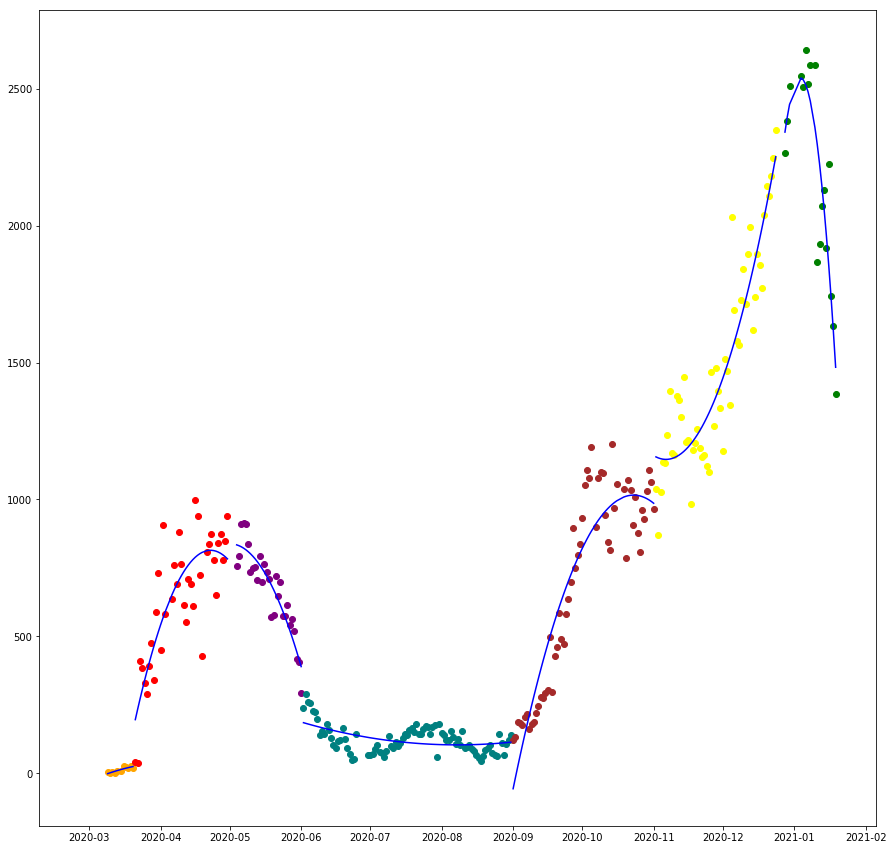

In [311]:
from sklearn.metrics import r2_score
first = qc[qc['ObservationDate'] < imp_dates[0]].reset_index()
second = qc[(qc['ObservationDate'] > imp_dates[0]) & (qc['ObservationDate'] < imp_dates[1])].reset_index()
third = qc[(qc['ObservationDate'] > imp_dates[1]) & (qc['ObservationDate'] < imp_dates[2])].reset_index()
fourth = qc[qc['ObservationDate'] > imp_dates[2]].reset_index()

estimates = []
filters = [None, 1000, 1000, 300, 1250, None, 2650,None]
date_filters = [None, None, None, None, None, None, None]#'2020/06/01'
colors = ['orange', 'red', 'purple', 'teal', 'brown', 'yellow', 'green']
degrees = [2, 2, 2, 2, 2, 2, 2]
fit_colors = ['orange', 'red', 'purple', 'teal']
plt.figure(figsize=(15.,15.))

for i in range(len(sets)):
    if filters[i] != None:
        sets[i] = sets[i][sets[i]['DailyConfirmed'] <= filters[i]]
    if date_filters[i] != None:
        sets[i] = sets[i][sets[i]['ObservationDate'] <= pd.to_datetime(date_filters[i])]

scores = []
coef1 = []
coef2 = []
ones = []
twos = []
        
for i in range(len(sets)):
    x = sets[i]['ObservationDate'][:, np.newaxis]
    y = sets[i]['DailyConfirmed']
    X = sm.add_constant(sets[i]['DateUnix'])
    deg = degrees[i]
    poly = PolynomialFeatures(degree = deg) 
    X_poly = poly.fit_transform(X)
    pr_model = LinearRegression().fit(X_poly, y)
    y_hat = pr_model.predict(X_poly)
    plt.scatter(x,y, color=colors[i])
    plt.plot(x,y_hat, color='blue')
    
    est = sm.OLS(y,sm.add_constant(sets[i][['DateUnix','DateUnix2']])).fit()
    
    summary = est.summary2().tables[1]
    r_squ = r2_score(y, y_hat)
    pvalues = summary['P>|t|']
    coeffs = summary['Coef.']
    print(" ")
    print("For:",tranches[i], "R2", r_squ)
    print(summary)
    scores.append(r_squ)
    coef1.append(coeffs['DateUnix'])
    coef2.append(coeffs['DateUnix2'])
    ones.append(pvalues['DateUnix'])
    twos.append(pvalues['DateUnix2'])
    
res = pd.DataFrame({
    'tranche': tranches,
    'r2': scores,
    'coeff1': coef1,
    'coeff2': coef2,
    'p_deg1': ones,
    'p_deg2': twos,
    'color': colors
})
res